# 9 巡回セールスマン問題

この章では、非常に有名な組合せ最適化問題の一つ、巡回セールスマン問題(Traveling salesman problem: TSP)
をPyQUBOでモデリングしてOpenJijを使って計算する方法を紹介します。

## 巡回セールスマン問題 (TSP)

ある都市をセールスマンが回って一周することを考えます。
その際に一周する経路が最短距離となる経路を見つける問題です。  
都市集合を$V$としましょう。そして都市$i, j \in V$の間の距離を$d_{ij}$としましょう。  
巡回セールスマン問題は以下のように定式化されます。

0-1変数$x_{i,t} \in \{0, 1\}$は、セールスマンが$t$番目に都市$i$を訪れるときに1、そうでないときに0となる変数です。  
この変数を用いると経路の総距離$D$は以下のように定式化できます。

$$
D(\{x_{i,t}\}) = \sum_t \sum_{i < j} d_{ij}x_{i, t}x_{j, t+1}
$$

さらに$\{x_{i,t}\}$が1つの巡回路となるために以下の2つの制約条件が課されます。

- $t$番目にセールスマンは複数都市にいてはならない。
  $$\sum_i x_{i,t} = 1,~\forall t$$
- 都市は1度だけ回る。
  $$\sum_t x_{i,t} = 1,~\forall i \in V$$
  
つまりTSPはこの制約条件の元で総距離$D(\{x_{i,t}\})$を最小化する$\{x_{i,t}\}$を探す問題です。

### 2次制約無し2値最適化問題

さてこれをOpenJijに投げるために2次制約無し2値最適化問題(QUBO)で最小化するコスト関数(エネルギー)すると以下のようになります。

$$E = 
\sum_t \sum_{i < j} d_{ij}x_{i, t}x_{j, t+1}
+ \lambda_{time} \sum_t \left(\sum_i x_{i,t} - 1\right)^2
+ \lambda_{city} \sum_i \left(\sum_t x_{i,t} - 1\right)^2
$$

ここでは最もよく用いられているペナルティ法を用いました。
第二項と第三項は、TSPの定式化の制約条件を表しており、制約を見たしていない時はエネルギーが増加するように、つまりペナルティがつくようになっています。
等式制約は上記のように2次式でペナルティとすることが多いです。  
不等式制約は扱うにはいくつかの工夫をしなくては行けません。  
またペナルティ法以外にもQUBOへの定式化をする方法はいくつかあるのでぜひ他の方法も検討してみてください。

今回は一番オーソドックスな上記の方法を用います。  
ではこのQUBOをPyQUBOを用いて最適化してみましょう。

まずは都市の集合をランダムに生成します。

In [1]:
import numpy as np

def city_set(n):
    xy = np.random.uniform(0, 10, (n, 2))
    x, y = xy.T
    d = np.zeros((n, n))
    for i, (_x, _y) in enumerate(xy[:-1]):
        d[i, i+1:] = np.sqrt((_x - x[i+1:])**2 + (_y - y[i+1:])**2)
    d = (d + d.T)/2
    return d, xy

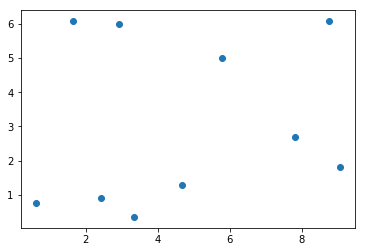

In [3]:
import matplotlib.pyplot as plt

d, xy = city_set(10)
plt.scatter(xy.T[0], xy.T[1])
plt.show()

#### PyQUBO を使ったモデリング

ではPyQUBOを使って上記のQUBOモデルをモデリングしてみましょう。

TSPの最適解となる巡回路はスタート地点を変えることによって解が複数存在することになります。  
なので都市の集合$V=\{0,...,n-1\}$のうち$i=n-1$をスタート地点かつゴール地点だとします。  
なので総距離は、
$$
\sum_{j=0}^{n-2}d_{n-1, j}x_{j,0}
+\sum_{t=0}^{n-2} \sum_{i=0}^{n-2}\sum_{j=i+1}^{n-1} d_{ij}x_{i,t}x_{j,t+1}
+\sum_{j=0}^{n-2}d_{j,n-1}x_{n-2, j}
$$
となります。これでモデリングしてみましょう。

In [4]:
from pyqubo import Array, Constraint, Placeholder, Sum
def make_tsp_model(d):
    n = len(d)
    x = Array.create('x', (n-1, n-1), 'BINARY')
    
    cost = Sum(0, n-1, lambda j: d[n-1][j]*x[j][0])
    cost += Sum(0, n-2, lambda t: Sum(0, n-2, lambda i: Sum(i+1, n-1, lambda j: d[i][j]*x[i][t]*x[j][t+1])))
    cost += Sum(0, n-1, lambda j: d[j][n-1]*x[j][n-2])
    
    # time constraint
    time_const = Constraint(
        Sum(0, n-1, lambda t: (Sum(0, n-1, lambda i: x[i][t])-1)**2),
        label='time'
    )
    
    # city constraint
    city_const = Constraint(
        Sum(0, n-1, lambda i: (Sum(0, n-1, lambda t: x[i][t]) - 1)**2),
        label='city'
    )
    
    total = cost + Placeholder('lam_t')*time_const + Placeholder('lam_c')*city_const
    
    return total.compile()

## OpenJijを使って解く

ではOpenJijを使ってTSPを解いてみます。

In [87]:
from pyqubo import solve_qubo
import openjij as oj

class TSPModel:
    def __init__(self, sampler):
        self.sampler = sampler
    
    def make_instance(self, n):
        d, xy = city_set(n)
        self.d = d
        self.xy = xy
        self.model = make_tsp_model(d)
        
    def solve(self, lam_t, lam_c):
        self.feed_dict = {'lam_t': lam_t, 'lam_c': lam_c}
        qubo, bias = self.model.to_qubo(feed_dict=self.feed_dict)
        response = self.sampler.sample_qubo(qubo,num_reads=10, num_sweeps=1000)
        self.response = response
#         return [solve_qubo(qubo) for _ in range(10)]
        return response.samples()
        
    def get_path(self, sol):
        n = len(self.d)
        path = [n-1]
        cost = 0.0
        for t in range(n-1):
            for i in range(n-1):
                if sol['x'][i][t] == 1:
                    cost += self.d[i][path[-1]]
                    path.append(i)
                    break
        path.append(n-1)
        return path, cost
        
    def decode(self, samples):
        path_list, cost_list = [], []
        for s in samples:
            sol, broken, e = self.model.decode_solution(
                dict(s), vartype='BINARY', feed_dict=self.feed_dict
            )
            if len(broken) == 0:
                path, cost = self.get_path(sol)
                cost_list.append(cost)
                path_list.append(path)
        self.cost_list = cost_list
        self.path_list = path_list
        
        min_p = np.argmin(self.cost_list)
        self.min_path = self.path_list[min_p]
        
    def plot_min_path(self):
        self._plot_path(self.min_path)
        
    def _plot_path(self, path):
        _xy = self.xy.T
        plt.plot(_xy[0][path], _xy[1][path])
        plt.scatter(_xy[0], _xy[1])
        
    def run(self, n, remake=True):
        if remake:
            print('make instance')
            self.make_instance(n)t
        print('solve problem ...')
        samples = self.solve(lam_t=10, lam_c=10)
        print('decode solution')
        self.decode(samples)
        
tsp_model = TSPModel(oj.SASampler(num_sweeps=1000))

In [88]:
tsp_model.run(n=8)

make instance
solve problem ...
decode solution


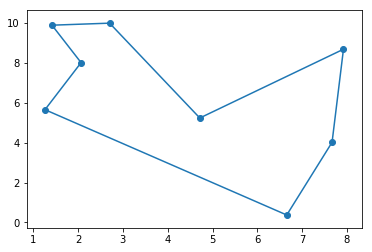

In [89]:
tsp_model.plot_min_path()

In [14]:
n = len(tsp_model.min_path) - 2
x = {'x[{}][{}]'.format(i, t): int(tsp_model.min_path[t] == i) for i in range(n) for t in range(n)}
sol, broken, e = tsp_model.model.decode_solution(x, vartype='BINARY', feed_dict={'lam_t': 0, 'lam_c': 0})

In [15]:
e

6.251282670576894

In [17]:
tsp_model.cost_list

[8.396913411233738,
 8.491971296076294,
 11.20739414373753,
 12.846042531701402,
 10.94744747097928,
 7.935831720636358,
 11.511164143375957,
 10.471143420747952,
 10.831070706081402,
 13.507430544589758]